In [32]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import welch,iirnotch,filtfilt
import struct
import time
from datetime import datetime
from scipy.signal import butter,iirnotch,filtfilt,hilbert,firwin
import pywt
import mne
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, Reshape, Conv1D, Dropout
from tensorflow.keras.layers import AveragePooling1D, UpSampling1D, Activation
from tensorflow.keras.layers import ZeroPadding1D
from tensorflow.keras.models import Model

fs = 256
dur = 300
sn = fs * dur
length_data=2048

In [2]:
class epilepsiae_block:
    def __init__(self,datafile,headfile):
        self.datafile=datafile
        self.headfile=headfile
        self.headInfo=self.read_headData(headfile)
        self.fs=self.headInfo['sample_freq']
        self.chn_names=self.headInfo['elec_names']
        self.dataHandle=self.open_dataFile(datafile)

    def read_headData(self,filename):
        head_dict={}
        with open(filename,'r') as fh:
            headData=fh.readlines()
            for line in headData:
                ind=line.strip().split('=')[0]
                cont=line.strip().split('=')[1]
                head_dict[ind]=cont
        head_dict['start_stamp']=datetime.strptime(head_dict['start_ts'],"%Y-%m-%d %H:%M:%S.%f").timestamp()
        head_dict['num_samples']=int(head_dict['num_samples'])
        head_dict['sample_freq']=float(head_dict['sample_freq'])
        head_dict['conversion_factor']=float(head_dict['conversion_factor'])
        head_dict['num_channels']=int(head_dict['num_channels'])
        head_dict['elec_names']=head_dict['elec_names'][1:-1].split(',')
        head_dict['duration_in_sec']=float(head_dict['duration_in_sec'])
        head_dict['sample_bytes']=int(head_dict['sample_bytes'])

        return head_dict

    def open_dataFile(self,filename):
        fh=open(filename,'rb')
        return fh


    def fetch_data(self,begin_t,end_t):
        begin_bytes=int(round(begin_t*self.headInfo['sample_freq'])*self.headInfo['sample_bytes']*self.headInfo['num_channels'])
        end_bytes=int(round(end_t*self.headInfo['sample_freq'])*self.headInfo['sample_bytes']*self.headInfo['num_channels'])
        if end_bytes>os.path.getsize(self.datafile):
            end_bytes=os.path.getsize(self.datafile)
        self.dataHandle.seek(begin_bytes)
        fetched_bytes=self.dataHandle.read(end_bytes-begin_bytes)
        fetched_data=struct.unpack('<{}h'.format(int((end_bytes-begin_bytes)/self.headInfo['sample_bytes'])),fetched_bytes)
        fetched_eeg=np.reshape(fetched_data,[-1,self.headInfo['num_channels']]).T
        fetched_eeg=-1*self.headInfo['conversion_factor']*fetched_eeg

        return fetched_eeg

    def __del__(self):
        self.dataHandle.close()

In [3]:
def datafetch(head_file, data_file):
    testdata = epilepsiae_block(data_file, head_file)

    chns = testdata.chn_names
    fs = testdata.fs
    data_dur = testdata.headInfo['duration_in_sec']
    #print(testdata.headInfo)

    eeg_chns = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ',
            'CZ', 'PZ']
    eeg_chns_bool=np.array([True if x in eeg_chns else False for x in chns])
    eeg_chns_names=np.array(chns)[eeg_chns_bool]

    # eeg_chns_names = eeg_chns
    tmp_data = testdata.fetch_data(0, data_dur)
    eeg_data = tmp_data[eeg_chns_bool]
    return eeg_data

In [57]:
iter_freqs = [
    {'name': 'Delta&Theta', 'fmin': 0.5, 'fmax': 8},
    #{'name': 'Theta', 'fmin': 4, 'fmax': 8},
    {'name': 'Alpha', 'fmin': 8, 'fmax': 13},
    {'name': 'Beta', 'fmin': 13, 'fmax': 35},
]
 
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
mne.set_log_level(False)
def TimeFrequencyWP(data, fs, wavelet, maxlevel = 8):
    result=[]
    wp = pywt.WaveletPacket(data=data, wavelet=wavelet, mode='symmetric', maxlevel=maxlevel)
    freqTree = [node.path for node in wp.get_level(maxlevel, 'freq')]
    freqBand = fs/(2**maxlevel)
    for iter in range(len(iter_freqs)):
        new_wp = pywt.WaveletPacket(data=None, wavelet=wavelet, mode='symmetric', maxlevel=maxlevel)
        for i in range(len(freqTree)):
            bandMin = i * freqBand
            bandMax = bandMin + freqBand
            if (iter_freqs[iter]['fmin']<=bandMin and iter_freqs[iter]['fmax']>= bandMax):
                new_wp[freqTree[i]] = wp[freqTree[i]].data
        result.append(new_wp.reconstruct(update=True))
        
    return result[0]

In [60]:
def Pretreatment(str):
    pass_band = [0.5*2/256, 40*2/256]
    b, a_filt = butter(1, pass_band, 'bandpass')
    head_file='C:/Users/Salvator/Desktop/data/'+str+'.head'
    data_file='C:/Users/Salvator/Desktop/data/'+str+'.data'
    eeg_data = datafetch(head_file,data_file)
    eeg_data=filtfilt(b,a_filt,eeg_data)
    result=[]
    for i in range(eeg_data.shape[0]):
        result.append(TimeFrequencyWP(eeg_data[i],256,wavelet='db4', maxlevel=8))
    eeg_data=np.array(result)
    eeg_data=np.reshape(eeg_data,(19,eeg_data.shape[1]))
    
    return eeg_data

In [61]:
data_list=[]
data_list.append(Pretreatment('16200102_0060'))
data_list.append(Pretreatment('16201102_0018'))
data_list.append(Pretreatment('16203102_0015'))
data_list.append(Pretreatment('16206102_0001'))
data_list.append(Pretreatment('16206102_0010'))
data_list.append(Pretreatment('16206102_0012'))

data_list.append(Pretreatment('16202102_0002'))
data_list.append(Pretreatment('16204102_0004'))
data_list.append(Pretreatment('16205102_0001'))
data_list.append(Pretreatment('16207102_0004'))
data_list.append(Pretreatment('16209102_0000'))

In [173]:
signal_A=[]
signal_B=[]
j=33*fs*60
while(j<33*fs*60+sn):
    signal_A.append(data_list[0][:,j:j+2048])
    j+=128
    
j=28*fs*60
while(j<28*fs*60+sn):
    signal_B.append(data_list[0][:,j:j+2048])
    j+=128
    
j=17*fs*60
while(j<17*fs*60+sn):
    signal_A.append(data_list[1][:,j:j+2048])
    j+=128
    
j=12*fs*60
while(j<12*fs*60+sn):
    signal_B.append(data_list[1][:,j:j+2048])
    j+=128
    
j=16*fs*60
while(j<16*fs*60+sn):
    signal_A.append(data_list[2][:,j:j+2048])
    j+=128
    
j=11*fs*60
while(j<11*fs*60+sn):
    signal_B.append(data_list[2][:,j:j+2048])
    j+=128
    
j=26*fs*60
while(j<26*fs*60+sn):
    signal_A.append(data_list[3][:,j:j+2048])
    j+=128
    
j=21*fs*60
while(j<21*fs*60+sn):
    signal_B.append(data_list[3][:,j:j+2048])
    j+=128
    
j=12*fs*60
while(j<12*fs*60+sn):
    signal_A.append(data_list[4][:,j:j+2048])
    j+=128
    
j=7*fs*60
while(j<7*fs*60+sn):
    signal_B.append(data_list[4][:,j:j+2048])
    j+=128
    
j=2*fs*60
while(j<2*fs*60+sn):
    signal_A.append(data_list[5][:,j:j+2048])
    j+=128
    
j=10*fs*60
while(j<10*fs*60+sn*2):
    signal_B.append(data_list[6][:,j:j+2048])
    j+=128
    
j=20*fs*60
while(j<20*fs*60+sn*2):
    signal_B.append(data_list[7][:,j:j+2048])
    j+=128
    
j=30*fs*60
while(j<30*fs*60+sn*2):
    signal_B.append(data_list[8][:,j:j+2048])
    j+=128
    
j=40*fs*60
while(j<40*fs*60+sn*2):
    signal_B.append(data_list[9][:,j:j+2048])
    j+=128

j=50*fs*60
while(j<50*fs*60+sn):
    signal_B.append(data_list[10][:,j:j+2048])
    j+=128

In [175]:
signal_A=np.array(signal_A)
signal_B=np.array(signal_B)

A_labels = np.ones(len(signal_A))
B_labels = np.zeros(len(signal_B))

X0 = np.concatenate((signal_A, signal_B), axis=0)
Y0 = np.concatenate((A_labels, B_labels), axis=0)

X=[]
Y=[]

for i in range(len(X0)):
    X.append(X0[i].T)
    Y.append(Y0[i].T)
X=np.array(X)
Y=np.array(Y)

print(X.shape)
print(Y.shape)

(12000, 2048, 19)
(12000,)


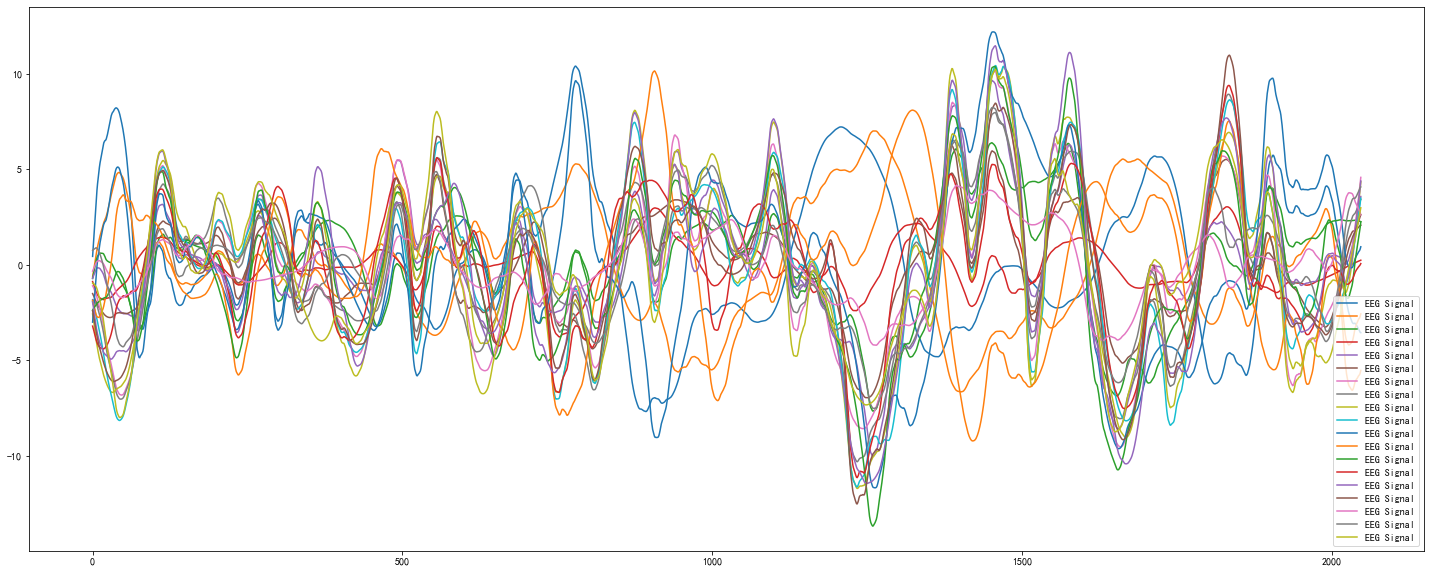

In [176]:
plt.figure(figsize=(25, 10))
plt.plot(X[0], label = 'EEG Signal')
plt.legend()

In [177]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
for i in range(len(X)):
    X[i]=scaler.fit_transform(X[i])

In [66]:
inputs = Input(shape=(length_data,19))
#ENCODER
x = Conv1D(32, 7, padding='same', strides=1)(inputs)
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=4)(x)
x = BatchNormalization(axis=-1, momentum=0.99)(x)
x = Dropout(0.5)(x)
x = Conv1D(32, 7, padding='same', strides=1)(x)
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=4, name='encoder_out')(x)

#DECODER
x = Conv1D(32, 7, padding='same', strides=1)(x)
x = Activation('relu')(x)
x = UpSampling1D(4)(x)
x = BatchNormalization(axis=-1, momentum=0.99)(x)

x = Conv1D(32, 7, padding='same', strides=1)(x)
x = Activation('relu')(x)
x = UpSampling1D(4)(x)
x = BatchNormalization(axis=-1, momentum=0.99)(x)

#x = ZeroPadding1D(padding=2)(x)
x = Conv1D(19, 7, padding='same', strides=1)(x)
x = Activation('tanh')(x)

model= Model(inputs, x)

print(model.summary())


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2048, 19)]        0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 2048, 32)          4288      
_________________________________________________________________
activation_5 (Activation)    (None, 2048, 32)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 512, 32)           0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 512, 32)           128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 512, 32)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 512, 32)           7200

In [178]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=20,
                                                    shuffle=True, stratify=Y)
print(X_train.shape)
print(X_test.shape)

(10800, 2048, 19)
(1200, 2048, 19)


In [217]:
model.compile(loss='mse',optimizer='adadelta')
history = model.fit(X_train, X_train, validation_data=(X_test, X_test),
                    epochs=50, batch_size=16)

Epoch 1/50
675/675 [==============================] - 110s 153ms/step - loss: 0.1832 - val_loss: 0.1477
Epoch 2/50
675/675 [==============================] - 99s 147ms/step - loss: 0.1634 - val_loss: 0.1379
Epoch 3/50
675/675 [==============================] - 99s 147ms/step - loss: 0.1485 - val_loss: 0.1292
Epoch 4/50
675/675 [==============================] - 99s 146ms/step - loss: 0.1367 - val_loss: 0.1214
Epoch 5/50
675/675 [==============================] - 96s 142ms/step - loss: 0.1269 - val_loss: 0.1148
Epoch 6/50
675/675 [==============================] - 96s 142ms/step - loss: 0.1187 - val_loss: 0.1083
Epoch 7/50
675/675 [==============================] - 96s 142ms/step - loss: 0.1118 - val_loss: 0.1029
Epoch 8/50
675/675 [==============================] - 96s 142ms/step - loss: 0.1057 - val_loss: 0.0983
Epoch 9/50
675/675 [==============================] - 96s 142ms/step - loss: 0.1006 - val_loss: 0.0943
Epoch 10/50
675/675 [==============================] - 96s 142ms/step - 

In [182]:
model.evaluate(X_test, X_test)

38/38 [==============================] - 1s 22ms/step - loss: 0.0756


0.07555189728736877

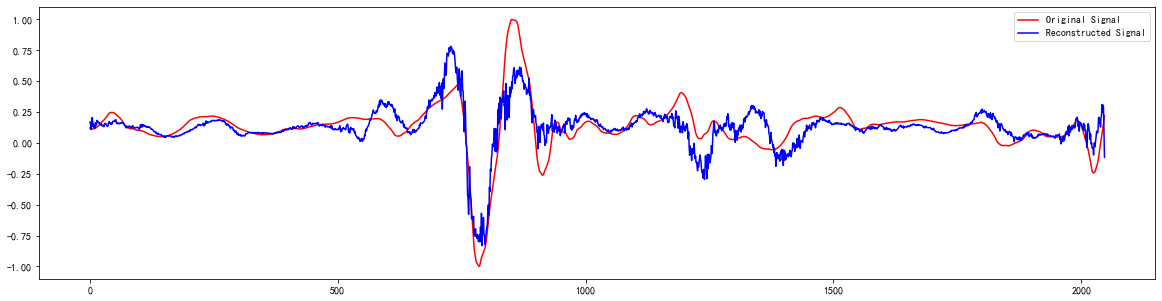

In [218]:
preds = model.predict(X_test)
plt.figure(figsize=(20, 5))
plt.plot(X_test[0][:,0], color='red', label = 'Original Signal')
plt.plot(preds[0][:,0], color='blue', label = 'Reconstructed Signal')
plt.legend() 

In [186]:
clf_in = model.input
clf_out = [layer.output for layer in model.layers if layer.name == 'encoder_out'][0]
clf_x = Flatten()(clf_out)
clf_x = Dense(1, activation='sigmoid')(clf_x)
clf = tf.keras.models.Model(inputs=clf_in,
                            outputs=clf_x)
print(clf.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2048, 19)]        0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 2048, 32)          4288      
_________________________________________________________________
activation_5 (Activation)    (None, 2048, 32)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 512, 32)           0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 512, 32)           128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 512, 32)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 512, 32)           7200

In [187]:
clf.compile(loss='binary_crossentropy',
            optimizer='sgd', metrics=['accuracy'])
history = clf.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                  epochs=50, batch_size=16)

Epoch 1/50
675/675 [==============================] - 15s 22ms/step - loss: 0.5396 - accuracy: 0.7396 - val_loss: 0.4881 - val_accuracy: 0.7925
Epoch 2/50
675/675 [==============================] - 15s 22ms/step - loss: 0.4092 - accuracy: 0.8071 - val_loss: 0.4178 - val_accuracy: 0.7950
Epoch 3/50
675/675 [==============================] - 15s 22ms/step - loss: 0.3649 - accuracy: 0.8358 - val_loss: 0.4124 - val_accuracy: 0.8333
Epoch 4/50
675/675 [==============================] - 15s 22ms/step - loss: 0.3402 - accuracy: 0.8459 - val_loss: 0.3640 - val_accuracy: 0.8367
Epoch 5/50
675/675 [==============================] - 15s 22ms/step - loss: 0.3082 - accuracy: 0.8629 - val_loss: 0.3555 - val_accuracy: 0.8583
Epoch 6/50
675/675 [==============================] - 15s 22ms/step - loss: 0.2908 - accuracy: 0.8746 - val_loss: 0.3172 - val_accuracy: 0.8567
Epoch 7/50
675/675 [==============================] - 15s 22ms/step - loss: 0.2762 - accuracy: 0.8813 - val_loss: 0.3230 - val_accuracy:

In [188]:
from sklearn.metrics import classification_report 


preds = np.around(clf.predict(X_test))
rep = classification_report(Y_test, preds)
print(rep)

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96       840
         1.0       0.92      0.90      0.91       360

    accuracy                           0.95      1200
   macro avg       0.94      0.93      0.94      1200
weighted avg       0.95      0.95      0.95      1200



### 后处理

53


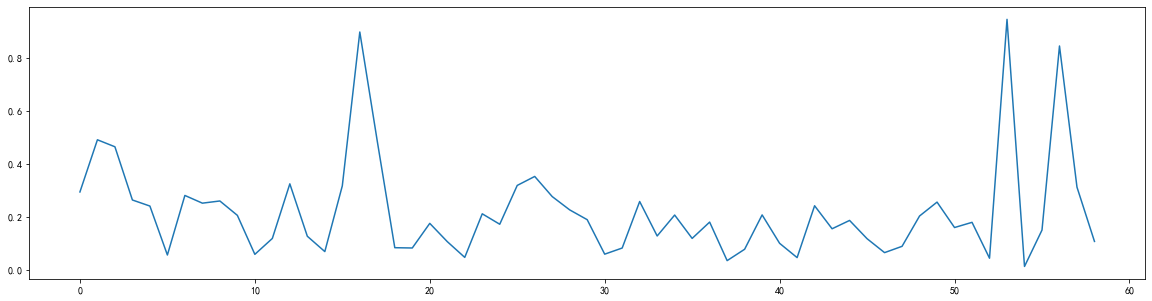

In [216]:
lxz=Pretreatment('16207102_0005')

X0=[]
j=0
while (j<(lxz.shape[1]-2048)):
    X0.append(lxz[:,j:j+2048])
    j+=256

X=[]
for i in range(len(X0)):
    X.append(X0[i].T)
    
X=np.array(X)

scaler = MinMaxScaler(feature_range=(-1, 1))
for i in range(len(X)):
    X[i]=scaler.fit_transform(X[i])
    

syx=clf.predict(X)

m=[]
for i in range(len(syx)//60):
    m.append(np.mean(syx[60*i:60*(i+1)]))
    
    
plt.figure(figsize=(20, 5))
plt.plot(m)

for i in range(len(m)):
    if m[i]>0.9:# and m[i+1]>0.8:
        print(i)
        break